In [1]:
import os
import cv2
import imghdr
import random
import fnmatch
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
dataset_path = '/kaggle/input/garbage-image-dataset'
dataset = list(os.listdir(dataset_path))
print(f"image classes in the data: {dataset}")

image classes in the data: ['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


In [3]:
# avoid OOM error by set the GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

# print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


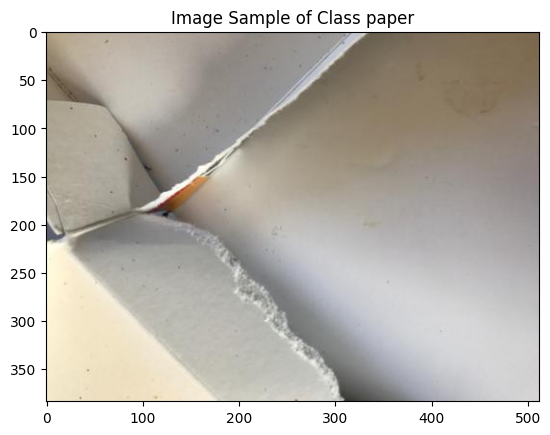

In [4]:
# sample image
index = random.choice(range(6))
exp_class = os.listdir(dataset_path)[index]
exp_image = os.listdir(os.path.join(dataset_path, exp_class))[0]
image = tf.keras.utils.load_img(os.path.join(dataset_path, exp_class, exp_image))
plt.imshow(image)
plt.title(f"Image Sample of Class {exp_class}")
plt.show()

# using CV2
# note that opencv use BGR instead of RGB color, so...
# exp = cv2.imread(os.path.join(data_dir, exp_class, exp_image))
# plt.imshow(cv2.cvtColor(exp, cv2.COLOR_BGR2RGB))

## **Load The Dataset**

In [5]:
# LOAD DATA
train_data, val_data = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size = (256,256),
    batch_size = 32,
    validation_split = 0.2,
    subset = 'both',
    label_mode = 'categorical',
    seed = 1234
)

# OPTIMIZE DATA 
AUTOTUNE = tf.data.AUTOTUNE

train_data_final = train_data.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_data_final = val_data.cache().prefetch(buffer_size = AUTOTUNE)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Using 505 files for validation.


## **Setting The Environment**

In [8]:
# get the GPUs
GPUs = tf.config.list_physical_devices('GPU')

# how many are there
num_GPUs = len(GPUs)
print(f"Number of GPU avail is {num_GPUs}")

Number of GPU avail is 2


In [9]:
# assign multiple GPUs
if GPUs:
    try:
        tf.config.set_logical_device_configuration(
            GPUs[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=2048),
            tf.config.LogicalDeviceConfiguration(memory_limit=2048)]
        )
        
        logical_GPUs = tf.config.list_logical_devices('GPU')
        print(len(GPUs), "Physical GPU", len(logical_GPUs), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

Virtual devices cannot be modified after being initialized


## **MODEL BUILDING**

In [22]:
def aug_model():
  model = tf.keras.Sequential([
      # AUGMENTATION LAYERS
      tf.keras.Input(shape=(256,256,3)),
      tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
      tf.keras.layers.RandomRotation(0.3, fill_mode='nearest'),
      tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest'),
      tf.keras.layers.RandomZoom(0.2, fill_mode='nearest')
  ])

  return model

In [23]:
# RESNET50 base model
base_model = tf.keras.applications.ResNet50(
    include_top = False,
    weights = 'imagenet',
    input_shape = (256,256,3)
)

# Freeze layer of the base model to PREVENT RETRAIN
base_model.trainable = False

# Create our owaug_modelel
model = tf.keras.Sequential([
    # add Augmentation model
    aug_model(),
    
    # add RESNET5
    base_model,
    
    # add our own model/configurations
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [24]:
model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate=1e-4),
    loss = 'categorical_crossentropy',  # for label encoder, use "sparse_categorical..." for one hot labels
    metrics = ['accuracy']
)

In [25]:
history = model.fit(
    train_data_final,
    epochs = 20,
    validation_data = val_data_final,
    verbose = 1
)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 320ms/step - accuracy: 0.5132 - loss: 2.6838 - val_accuracy: 0.7465 - val_loss: 0.8224
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.7475 - loss: 0.6986 - val_accuracy: 0.7802 - val_loss: 0.7003
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 279ms/step - accuracy: 0.8166 - loss: 0.5413 - val_accuracy: 0.8020 - val_loss: 0.6353
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 276ms/step - accuracy: 0.8352 - loss: 0.4567 - val_accuracy: 0.8198 - val_loss: 0.5483
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.8394 - loss: 0.4532 - val_accuracy: 0.8475 - val_loss: 0.5396
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.8509 - loss: 0.4325 - val_accuracy: 0.8396 - val_loss: 0.5588
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 276ms/step - accuracy: 0.8520 - loss: 0.3972 - val_accuracy: 0.8337 - val_loss: 0.5063
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 275ms/step - accuracy: 0.8758 - loss: 0.3537 - val_accu

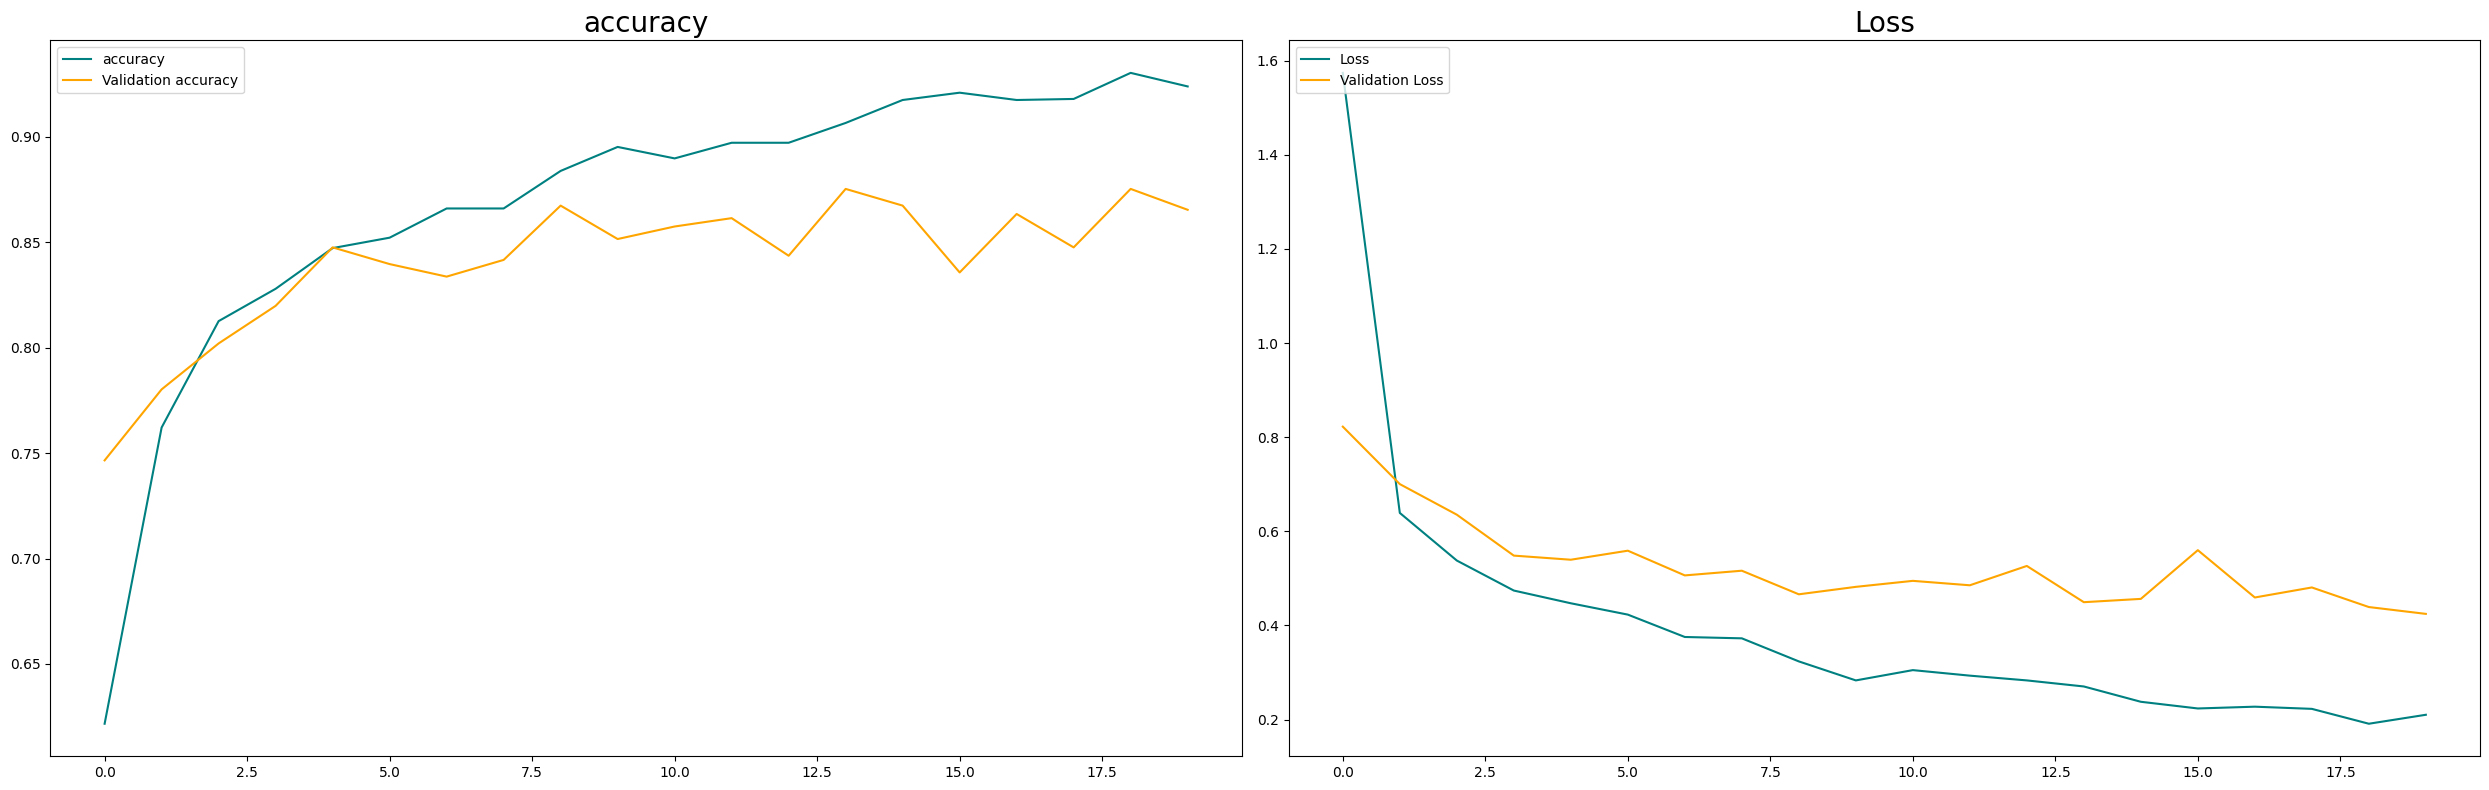

In [26]:
# plot performance
fig, axs = plt.subplots(1,2, figsize=(25,8))

axs[0].plot(history.history['accuracy'], color='teal', label='accuracy')
axs[0].plot(history.history['val_accuracy'], color='orange', label='Validation accuracy')
axs[0].set_title('accuracy', fontsize=20)
axs[0].legend(loc='upper left')

axs[1].plot(history.history['loss'], color='teal', label='Loss')
axs[1].plot(history.history['val_loss'], color='orange', label='Validation Loss')
axs[1].set_title('Loss', fontsize=20)
axs[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

## **Exception Model**

In [44]:
# RESNET50 base model
base_model = tf.keras.applications.Xception(
    include_top = False,
    weights = 'imagenet',
    input_shape = (256,256,3)
)

# Freeze layer of the base model to PREVENT RETRAIN
for layer in model.layers:
    layer.trainable = False

# Create our owaug_modelel
model = tf.keras.Sequential([
    # add Augmentation model
    aug_model(),
    
    # add RESNET5
    base_model,
    
    # add our own model/configurations
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [45]:
model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate=5e-5),
    loss = 'categorical_crossentropy',  # for label encoder, use "sparse_categorical..." for one hot labels
    metrics = ['accuracy']
)

In [46]:
history = model.fit(
    train_data_final,
    epochs = 20,
    validation_data = val_data_final,
    verbose = 1
)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.4621 - loss: 1.4916 - val_accuracy: 0.6990 - val_loss: 0.9672
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.7709 - loss: 0.6094 - val_accuracy: 0.7901 - val_loss: 0.6547
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8192 - loss: 0.5068 - val_accuracy: 0.8436 - val_loss: 0.4705
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8697 - loss: 0.3725 - val_accuracy: 0.8139 - val_loss: 0.5925
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8733 - loss: 0.3550 - val_accuracy: 0.8515 - val_loss: 0.4405
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8943 - loss: 0.2960 - val_accuracy: 0.8673 - val_loss: 0.3902
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8905 - loss: 0.3091 - val_accuracy: 0.8634 - val_loss: 0.3974
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9105 - loss: 0.2469 - val_accuracy: 0.8535 - val_loss

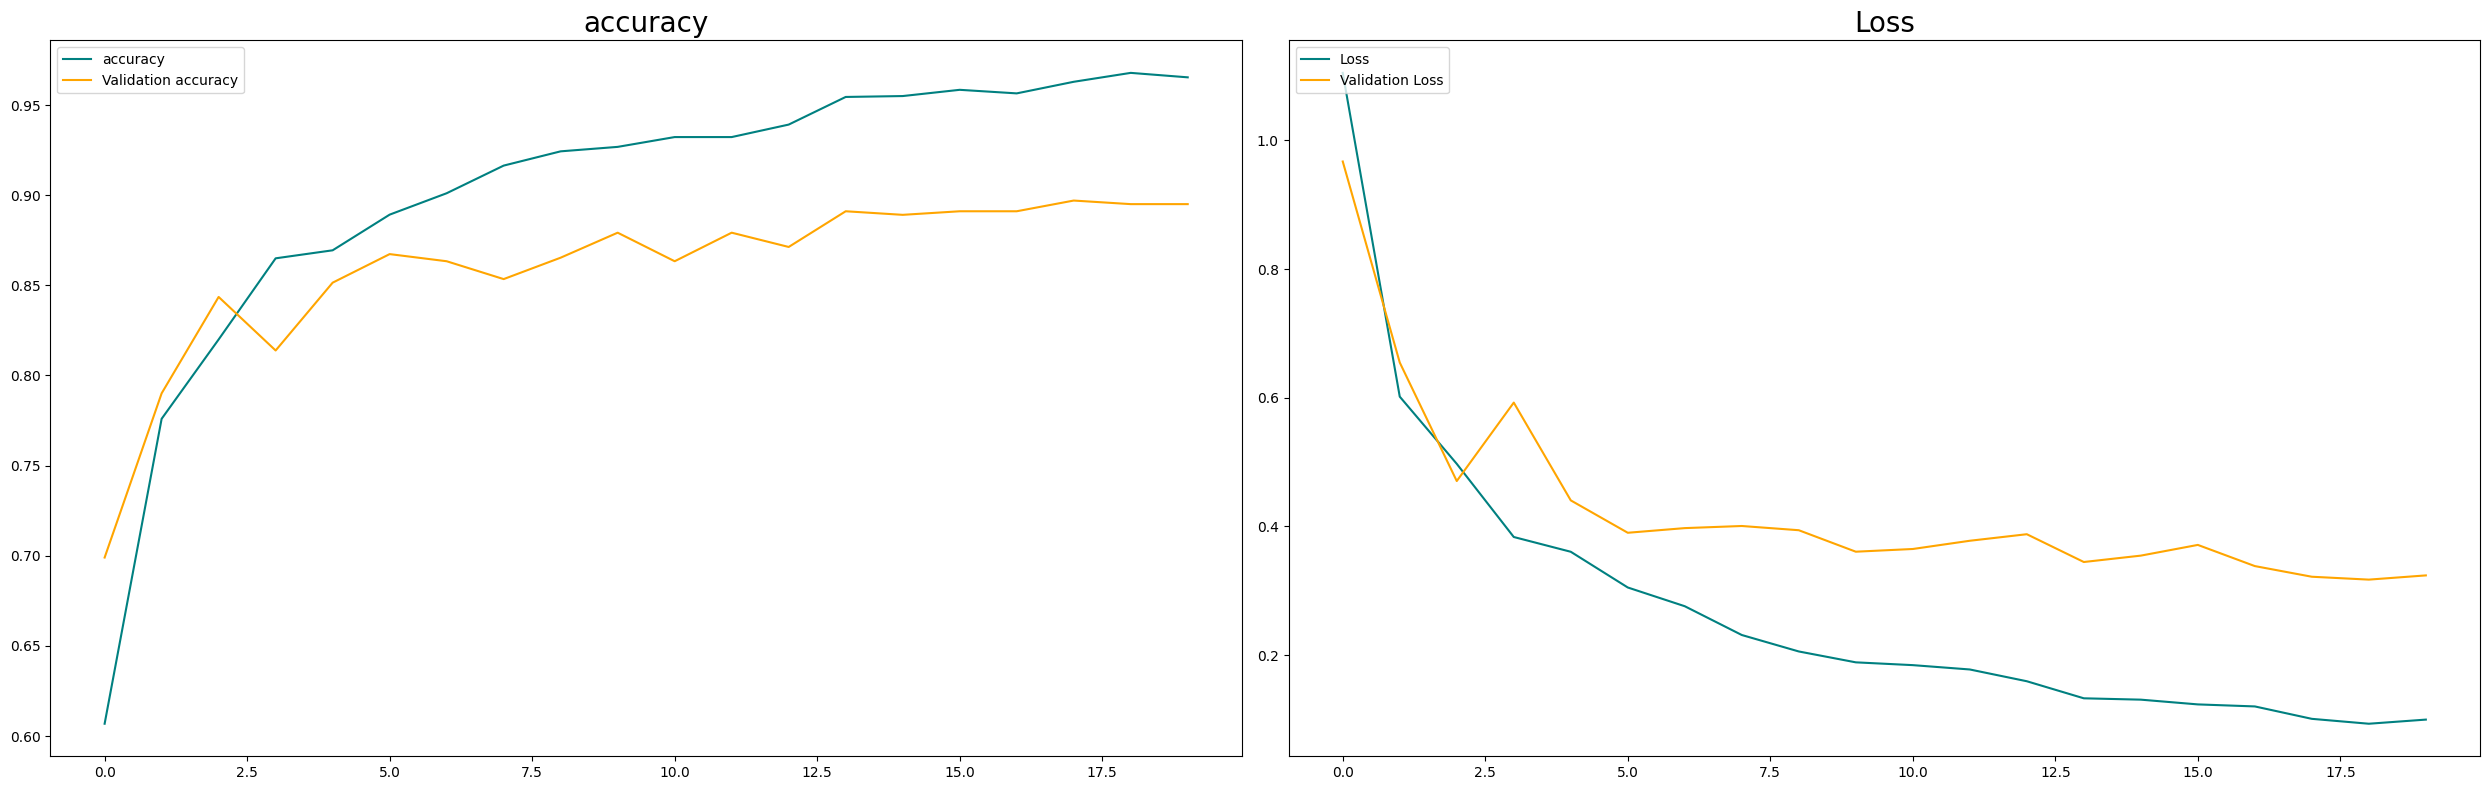

In [47]:
# plot performance
fig, axs = plt.subplots(1,2, figsize=(25,8))

axs[0].plot(history.history['accuracy'], color='teal', label='accuracy')
axs[0].plot(history.history['val_accuracy'], color='orange', label='Validation accuracy')
axs[0].set_title('accuracy', fontsize=20)
axs[0].legend(loc='upper left')

axs[1].plot(history.history['loss'], color='teal', label='Loss')
axs[1].plot(history.history['val_loss'], color='orange', label='Validation Loss')
axs[1].set_title('Loss', fontsize=20)
axs[1].legend(loc='upper left')

plt.tight_layout()
plt.show()